# DREDge: minimal introductory demo

This notebook shows some of the main points of DREDge on already-preprocessed example data
included with this code repository in `notebook/example_data/`. It's mean to illustrate the
application of DREDge on action potential data from a Neuropixels probe without requiring users
to download large raw data (typically, tens of gigabytes). So, before starting, let's point out
where users can go if they want to run this tool on their own raw recordings (from Neuropixels
or other probes):
 - For human intraoperative recordings, the local field potential is often better than spikes
   for motion estimation. See the demo notebook in `notebook/lfp_registration_and_interpolation_demo.ipynb`.
 - For users who want a seamless integration of DREDge's motion estimation with spike sorters,
   the SpikeInterface project has created a seamless interface. See our README.md and their
   webpage https://spikeinterface.readthedocs.io/en/latest/modules/motion_correction.html for
   instructions on how to run DREDge as a preprocessing step for sorters like Kilosort and
   Spyking Circus.
 - For users who want more control over the motion correction (for instance, who bring their own
   spikes detected by non-SpikeInterface pipelines), the demo at `notebook/ap_registration.ipynb`
   is of interest. Users with chronic recordings may be interested in `notebook/ap_chronic_demo.ipynb`.
   Users who would like to use DARTsort's detection and localization may check out
   https://github.com/cwindolf/dartsort/blob/main/notebook/dartsort_dredge_demo.ipynb.

This demo notebook will show how to use the spike-based registration pipeline on spikes which
were already extracted using the DARTsort pipeline demonstrated in the link in the last bullet
above from a Neuropixels 2 recording with zig-zag imposed motion (Steinmetz et al., Science 2021).
The raw data is publicly available [at this Figshare repository][https://figshare.com/articles/dataset/_Imposed_motion_datasets_from_Steinmetz_et_al_Science_2021/14024495?file=26476589], and the
specific dataset used was dataset1/p2. Spikes were extracted, and only spikes from t=750-1500s
were retained just to keep the file size small, and since this was the time region during which
the zig-zag motion was imposed.


### Running the demo

To run this notebook, follow the instructions in the README.md and then run `$ jupyter lab` from
within your environment, where you can open and run this notebook. For example, to install everything
from scratch on a MacBook with no GPU, the following commands were used from within the `dredge/` base
folder (where README.md lives).

```
mamba create -n dredge python=3.11 numpy scipy h5py tqdm jupyterlab seaborn numba scikit-learn
mamba activate dredge
conda install pytorch::pytorch torchvision torchaudio -c pytorch
pip install -r requirements.txt
pip install .
jupyter lab
```

Your particular command for installing PyTorch may vary depending on your platform; see README.md.
All of the outputs below, including the run times, correspond to this no-GPU laptop.

In [1]:
# import DREDge, numpy, and plotting libraries
import numpy as np
from dredge import motion_util, dredge_ap
import matplotlib.pyplot as plt

/Users/charlie/mambaforge/envs/dredge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load our example data
with np.load("example_data/dartsort_dataset1_p2_tstart750_tend1500.npz") as npz:
    # a n_channels x 2 array containing the probe's contact positions
    # this is usually obtained in SpikeInterface using the .get_channel_locations()
    # method of their recording objects
    geom = npz["geom"]
    
    # these are vectors of length n_spikes giving the spike amplitudes, positions
    # along the depth of the probe in microns, and peak times in seconds
    amplitudes = npz["denoised_amplitudes"]
    depths = npz["depths_um"]
    times = npz["times_seconds"]

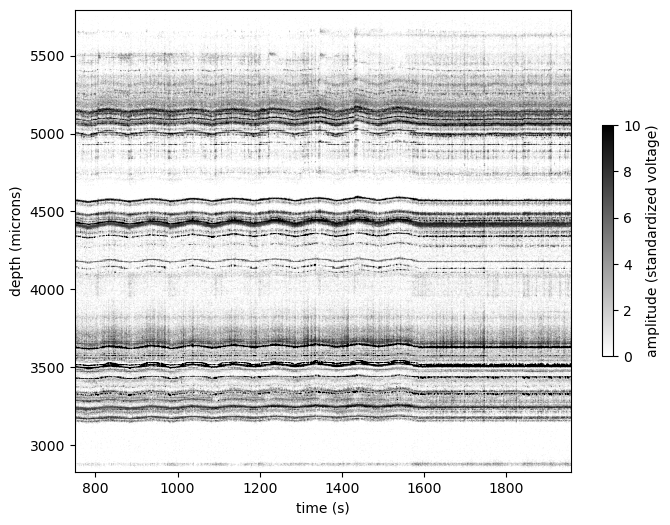

In [3]:
# start by plotting a "spike raster"
# this is a spatiotemporally binned version of the spikes above, showing
# the mean amplitude of all spikes in each bin, with darker colors indicating
# more high amplitude spikes

# the zig-zag motion is clearly visible!

fig, ax = plt.subplots(figsize=(8, 6))
im = motion_util.show_spike_raster(amplitudes, depths, times, ax, aspect="auto", cmap=plt.cm.binary, vmax=10)
plt.colorbar(im, ax=ax, label="amplitude (standardized voltage)", shrink=0.5)
plt.xlabel("time (s)")
plt.ylabel("depth (microns)")
plt.show()

In [4]:
# now, run nonrigid registration
# default parameters work well on acute mouse Neuropixels recordings (and others too)
motion_est, extra = dredge_ap.register(amplitudes, depths, times)

Solve: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.79it/s]


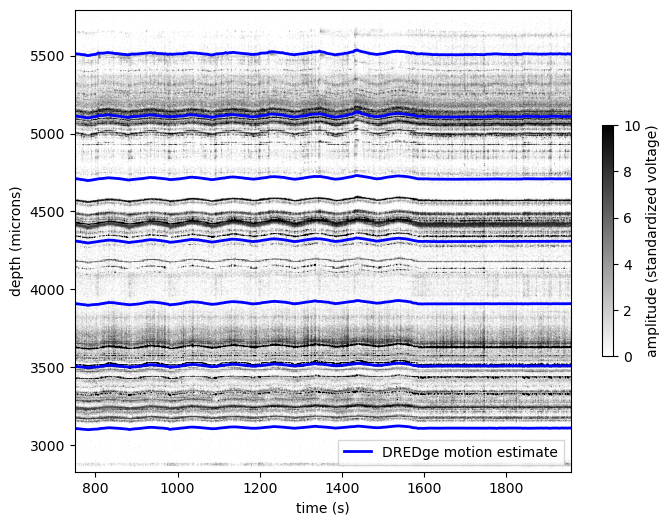

In [5]:
# to visualize the result, let's plot the estimated motion trace in each nonrigid window over
# the unregistered spike raster (from above)

fig, ax = plt.subplots(figsize=(8, 6))

im = motion_util.show_spike_raster(amplitudes, depths, times, ax, aspect="auto", cmap=plt.cm.binary, vmax=10)
plt.colorbar(im, ax=ax, label="amplitude (standardized voltage)", shrink=0.5)

lines = motion_util.plot_me_traces(motion_est, ax, label="DREDge motion estimate", color="b", lw=2)
plt.legend(fancybox=False, loc="lower right")

plt.xlabel("time (s)")
plt.ylabel("depth (microns)")
plt.show()


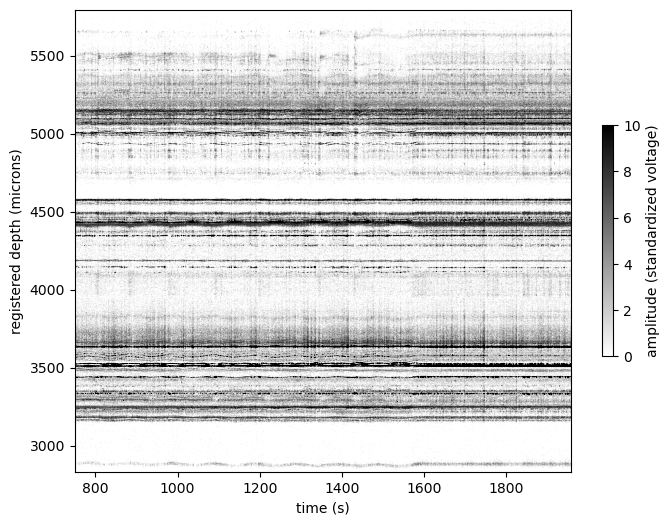

In [6]:
# the motion estimate does seem to follow the visually apparent drift!
# as an extra check, we can plot the motion-corrected spike positions

fig, ax = plt.subplots(figsize=(8, 6))

im = motion_util.show_registered_raster(motion_est, amplitudes, depths, times, ax, aspect="auto", cmap=plt.cm.binary, vmax=10)
plt.colorbar(im, ax=ax, label="amplitude (standardized voltage)", shrink=0.5)

plt.xlabel("time (s)")
plt.ylabel("registered depth (microns)")
plt.show()

In [7]:
# the motion estimate object returned by the register() function can also be used for
# other tasks. for instance, one can get the motion-corrected spike positions:
registered_depths = motion_est.correct_s(times, depths)

In [8]:
# it can also be used to interpolate a recording for motion correction, as in Kilosort>=2.5
# the helper function motion_util.get_interpolated_recording() interfaces with SpikeInterface
# to provide this service.
# although, SpikeInterface's included implementation of DREDge is likely easier to use in
# that case. again, see: https://spikeinterface.readthedocs.io/en/latest/modules/motion_correction.html